# Reproducing CON/FPN Connectome

The goal of this notebook is to extract cingulo-opecular (CON) and fronto-parietal (FPN) control networks from julia2018 resting-state dataset. Those two networks define control-related connectome with regions from all over the brain. In particular, they forms 4 clusters of nodes in CON, FPN, the cerebellum, and TPJ.

Here, I will try to use the same method as explained in the [paper]() to create the same connectome using resting-state data from another dataset. For the sake of comperability, the same set of parameters, and maybe the same visualizations, will be used.

**Method Summary**:

**ROIs**: Dosenbach2007 compiled a custom list of cognitive control ROIs based on a systematic review of the litertures. All the ROIs had been previously shown to carry either sustained, start-cue, or error-related activity, or a combination of these signals. They also added 5 mirrored ROIs based on the fact the resting-state signals are symetric, and excluded two ROIs in the inferior temporal cortex due to susceptibility to inhomogeneity artifacts. The final list contains 39 ROIs spreading across the whole brain and the cerebellum.

Those ROIs are only defined by the center coordinates and a sphere of size 12mm. Therefore, a spherical atlas will be created and used to extract those regions. However, the same team later developed an improved atlases that contain more regions (see TODO and TODO). Those improved atlases are already available in Nilearn via the following functions: `nilearn.datasets.fetch_coords_dosenbach_2010` and `TODO`.



In [2]:
project_dir = '../..'

## Parameters

Before starting the analysis, let's expicitly define some of the parameters that are appiled in Dosenbach2007 analysis:

- smoothing fwhm: 6mm
- filtering: 0.009 Hz < f < 0.08 Hz
- ROI sphere radius: 12mm
- overlapping ROIs: TODO
- T1: (TE = 4ms, MR frame = 9.7ms, TI = 300ms, flip angle = 12°, 128 slices with 1.25 ´ 1 ´ 1-mm voxels).
- BOLD: (volume TR = 2.5s, inplane resolution 3.75 ´ 3.75 mm, T2* evolution time = 50ms, a = 90°).
- correlation threshold (r): 0.20, which produced 61 edges in the connectivity graph.


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from nilearn import input_data, plotting, image
from nilearn.connectome import ConnectivityMeasure

from bids.reports import utils as bids_utils
from bids import BIDSLayout

import networkx as nx

Now we need to define ROIs and, respectively, their coordinations. Throughout this anallysis we will use standard coordinatio system of TODO.

ROIs are already extracted from the Dosenbach2007 paper, and is available in `data/dosenbach2007/ROIs.csv` file. When loaded, there must be 39 ROIs and for each ROI, 3 coordinates in X, Y, and Z dimensions.

In [4]:
# relative to the notebook's path
ROIs = pd.read_csv(f'{project_dir}/data/dosenbach2007/ROIs.csv')

labels = ROIs['ROI'].values.tolist()
coords = ROIs[['coord_x', 'coord_y', 'coord_z']].values

assert len(labels) == 39 and coords.shape == (39, 3)

Next, we load the preprocessed resting-state data of julia2018 dataset via BIDS interface. The data we need includes BOLD images, brain masks of those BOLDs, and fmriprep confounds for each subjects.

Note that BIDS also provides access to some metadata such as TR and subject ids. Instead of manually defining those variables, we will use BIDS interface to extract them.

In [5]:
# load data
layout = BIDSLayout(f'{project_dir}/data/julia2018/bids', derivatives=True)
subjects = layout.get_subject()

images = layout.get(task='rest', desc='preproc', suffix='bold', scope='derivatives', extension='nii.gz', return_type='filename')
mask_images = layout.get(task='rest', desc='brain', suffix='mask', scope='derivatives', extension='nii.gz', return_type='filename')
confounds_files = layout.get(task='rest', desc='confounds', suffix='timeseries', scope='derivatives', extension='tsv', return_type='filename')

confounds_cols = ['trans_x', 'trans_y', 'trans_z','rot_x','rot_y','rot_z','global_signal','a_comp_cor_00','a_comp_cor_01']

#TODO: slice thickness
TR = layout.get_tr()

To extract ROI time-series from the BOLD images with repect to a list of coordinations, we first need to create a spheres masker that creates a uniform sphere around each coordination; that is (x, y, z) of an ROI. Like Dosenbach2007, we use spheres of 12mm radius around ROI center points.

The example plot below shows the ROIs on the brain with 12mm of radius around the center. Note that some ROIs are overlapping, hence we allow masker to use one voxel for multiple ROIs; even though, this overlap doesn't mean we are applying a probabilisic atlas.

The masker's role is to extract time-series, but it also provide interfaces to low-pass and high-pass fitlers, detrending/normaizing signals, brain-masking, and smoothing the voxels prior to the extraction. Here we use parameters that are applied in the Dosenbach2007 paper.

In [6]:
example_masker = input_data.NiftiSpheresMasker(
    coords,
    radius=8,  # mm
    mask_img=mask_images[0],
    allow_overlap=True,
    detrend=True, standardize=True,
    low_pass=0.08, high_pass=0.009,
    t_r = TR,
    smoothing_fwhm=6, # mm
    )

plotting.view_markers( 
       coords, 
       title='Dosenbach2007 ROIs')

To make sure that markers and images are in the same coordination system, let's plot an averaged BOLD image and mark the vmPFC on it.

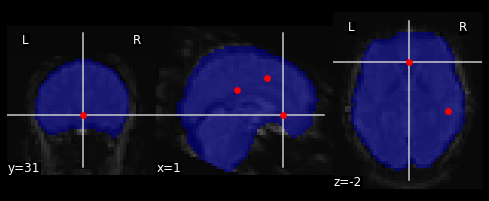

In [7]:
vmPFC_coords = (1,31,-2)  # MNI coords

disp = plotting.plot_roi(
        mask_images[0],
        image.mean_img(images[0]),
        cut_coords=(vmPFC_coords),)

disp.add_markers(coords,marker_size=32)  # marker_size is NOT in mm, but points
plt.show()

Now it's time to apply the ROI mask to the voxels, rule out confounds, and create time-series for each ROI. The output will be a matrix of shape (ROIs * time_points). There are 125 time points in our resting session (that is 375 seconds for each subject).

The output plot shows time-series of the first subject. X-axis is the time, and Y-axis is the ROI index (out of 39 ROIs).

Note that Nilearn produces time-series in tidy format, which results in a matrix that time is NOT in the x-axis. Therefore, here the output figure was flipped to match the "X is time", only for the sake of visualization.


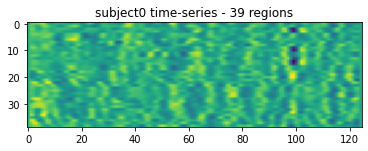

In [8]:
# extract ROI timeseries

timeseries = []

for img, mask_img, confounds in zip(images, mask_images, confounds_files):
    masker = input_data.NiftiSpheresMasker(
        coords, radius=12,
        mask_img=mask_img,
        allow_overlap=True,
        detrend=True, standardize=True,
        low_pass=0.08, high_pass=0.009,
        t_r = TR,
        smoothing_fwhm=6,
        verbose=0)
        # memory='tmp/nilearn_cache', memory_level=1,
        # for some reasons, using cache causes signal extraction to fail
    confounds = pd.read_csv(confounds, sep='\t')[confounds_cols].values
    ts = masker.fit_transform(img, confounds=confounds)
    timeseries.append(ts)

timeseries = np.array(timeseries)

plt.imshow(timeseries[0].T)
plt.title('subject0 time-series - {} regions'.format(timeseries[0].shape[1]))
plt.show()

Let's store time-series before further analysis of connectomes:

In [14]:
# store time-series for further analyses
np.savez_compressed(f'{project_dir}/outputs/julia2018_resting_timeseries', timeseries=timeseries, labels=labels, coords=coords, subjects=subjects)

Now, having unconfounded timeseries of all ROIs, next step would be measuring how two given ROIs covary over time.

We use Nilearn's ConnectivityMeasure to extract a covariate matrix that contains, for each subject, the Pearson's correlation of all time-series pairs. The output, which we call connectome, would be of size (subject*ROIs*ROIs).

In addition to subject-level connectome, Nilearn produces an averaged connectome across all subjects. We will use this averaged connectome to study the CON and the FPN networks. Below, you can see the average connectome in two different ways. First is a correlation matrix, and then connectome in the brain.


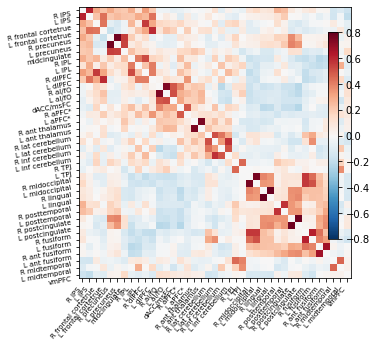

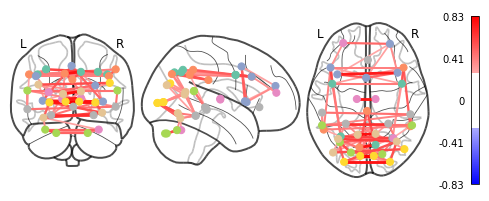

In [9]:

cm = ConnectivityMeasure(kind='correlation')
connectomes = cm.fit_transform(timeseries)



# visualize average connectome
mean_conn = cm.mean_

# store mean_conn and labels in outputs/ folder
mean_conn_df = pd.DataFrame(mean_conn)
mean_conn_df.index = labels
mean_conn_df.columns = labels
mean_conn_df.to_csv(f'{project_dir}/outputs/julia2018_resting_connectome.all_subjects.tsv', index=True, sep='\t')

np.fill_diagonal(mean_conn, 0)  # improves visualization!

plotting.plot_matrix(mean_conn, labels=labels,
                     vmax=0.8, vmin=-0.8,
                     colorbar=True)

disp = plotting.plot_connectome(mean_conn, coords,
                                edge_threshold="90%",
                                colorbar=True)

plt.show()


Dosenbach2007 then applied a fixed threshold to the connectivity matrix that we produced above, and plotted the remianing networks.

Although the threshod of 0.2 was used to binerize the correlation matrix, here we use 0.32 which keeps the extract same number of edges in the graph as seen in Dosenbach2007. With this threshold, 61 edges remains.

The output figure reflects two different aspects of the connectome:

1. distance between nodes shows how much they are correlated (by using spring layout), and
2. node colors show the network they belonged in the actual Dosenbach2007 paper.

61 edges remained after thresholding.


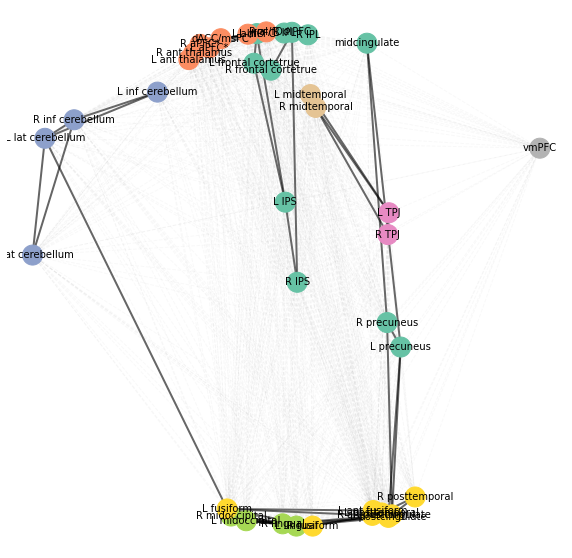

In [10]:
threshold = 0.32  # 61 edges remain with this value (as in Dosenbach2007)

plt.figure(1,figsize=(10,10)) 

# colors
rgb_values = sns.color_palette("Set2", len(ROIs['Comp'].unique()))
colors = [rgb_values[c-1] for c in ROIs['Comp'].to_list()]  # Map label to RGB

G = nx.from_numpy_matrix(mean_conn)

e_large = [(u, v) for (u, v, d) in G.edges(data=True) if abs(d["weight"]) > threshold]
e_small = [(u, v) for (u, v, d) in G.edges(data=True) if abs(d["weight"]) <= threshold]

print('{} edges remained after thresholding.'.format(len(e_large)))

initial_pos=None
initial_pos = nx.circular_layout(G)
pos = nx.spring_layout(G, k=.3, weight='weight', pos=initial_pos)

# draw nodes
nx.draw_networkx_nodes(G, pos, node_size=400, node_color=colors)

# draw edges
nx.draw_networkx_edges(G, pos, edgelist=e_large, alpha=0.6, width=2)
nx.draw_networkx_edges(
    G, pos, edgelist=e_small, width=1, alpha=0.05, edge_color='gray', style="dashed"
)

nx_labels = {n:lab for n,lab in enumerate(labels)}
# labels
nx.draw_networkx_labels(G, pos, labels=nx_labels, font_size=10)

plt.axis("off")
plt.show()


# method 2 (non-colored nodes)
# plt.figure(1,figsize=(10,10)) 

# df = pd.DataFrame(np.tril(mean_conn)).stack().reset_index()
# df.columns = ['source', 'target', 'weight']
# df = df.query('weight >= @threshold')
# G = nx.from_pandas_edgelist(df)
# nx.draw(G,
#         pos=pos,
#         with_labels=True,
#         labels=nx_labels,
#         node_color='orange', edge_color='gray',
#         node_size=400, font_size=10)

# plt.show()

In [11]:
# from IPython.display import Image
# import graphviz

# A = nx.drawing.nx_pydot.to_pydot(G)
# graphviz.Source(A)